## Limpiar datos de accidentes de bici

In [1]:
import geopandas as gpd
import numpy  as np
import pandas as pd
import requests
import seaborn as sns
import time

from io import StringIO

In [2]:
%matplotlib inline

In [3]:
# FROM LINKS TO LOAD DATA IN MEMORY AS A LIST OF DATAFRAMES
# Los datos de a ccdentes de bicicletas proceden de 
# cada link tiene la siguiente estructura
# ---
# los años disponibles son:
# 
# 
# 
# TODO: Terminar docu

url_constructor = 'https://datos.madrid.es/egob/catalogo/{code}-{y}-{name}.csv' 
ind_meta = {
    'name': 'accidentes-bicicleta', 
    'code': 300110,
    'years': set(range(0, 25, 2))  # NOTE: los codigos van del 0 al 25, cogiendo sólo numeros pares
}


def construct_url(params:dict, constructor:str=url_constructor) -> str:
    """ Given a set of parameters, construct a viable url to fetch data

    Args:
        params (dict): with parameters to implement in the constructor
        constructor (str): bas string for all urls
    
    Return:
        str: url as a string
    """
    url = url_constructor.format(**{
        'code': params.get('code',      'NOT_VALID'),
        'y':    params.get('year_code', 'NOT_VALID'),
        'name': params.get('name',      'NOT_VALID'),
    })

    if 'NOT_VALID' not in url: 
        return url
    else:
        raise ValueError(f"params passed NOT VALID: {params}")


def pythonise_string(name:str):
    """ Given a string, returns its pythonise version
    """
    return name.lower().replace(' ', '_')


def dataframe_from_url(url:str, sep:str=';', default_encoding:str='latin1'):
    """ Parses a csv link to a DataFrame object. Excepted read_csv params are that
    the csv has dot-comma separator (as usual for spanish sources) and utf-8 encoding,
    although latin1 is as common as utf8.

    Args:
        url (str)

    Returns:
        df (DataFrame)
    """
    response = requests.get(url)

    if response.status_code == 200 and response.encoding:

        res_encoding = response.encoding if response.encoding else default_encoding
        content = StringIO(str(response.content, res_encoding))
        
        try: 
            df = pd.read_csv(content, sep=sep, low_memory=False)
            
        except OSError:
            df = pd.read_csv(content)
        finally:
            df.columns = [pythonise_string(col) for col in df.columns]
            print(f"Done parsing {url}")
    
        return df

    else:
        print(f"Couldnt fetch data from {url}")



##############################################################################

# Inits
dfs_by_year = []
params = dict.fromkeys(['code', 'year_code', 'name'])
params.update({k: ind_meta[k] for k in ind_meta if k in params})

# Iter
start = time.perf_counter()
for year_code in ind_meta.get('years'):

    params.update({'year_code': year_code})
    url = construct_url(params=params)
    
    dfs_by_year.append(dataframe_from_url(url))

end = time.perf_counter()
print(f"Done fetching all data: {len(dfs_by_year)} \t time: {end-start} secs")

Done parsing https://datos.madrid.es/egob/catalogo/300110-0-accidentes-bicicleta.csv
Done parsing https://datos.madrid.es/egob/catalogo/300110-2-accidentes-bicicleta.csv
Done parsing https://datos.madrid.es/egob/catalogo/300110-4-accidentes-bicicleta.csv
Done parsing https://datos.madrid.es/egob/catalogo/300110-6-accidentes-bicicleta.csv
Done parsing https://datos.madrid.es/egob/catalogo/300110-8-accidentes-bicicleta.csv
Done parsing https://datos.madrid.es/egob/catalogo/300110-10-accidentes-bicicleta.csv
Done parsing https://datos.madrid.es/egob/catalogo/300110-12-accidentes-bicicleta.csv
Done parsing https://datos.madrid.es/egob/catalogo/300110-14-accidentes-bicicleta.csv
Done parsing https://datos.madrid.es/egob/catalogo/300110-16-accidentes-bicicleta.csv
Done parsing https://datos.madrid.es/egob/catalogo/300110-18-accidentes-bicicleta.csv
Done parsing https://datos.madrid.es/egob/catalogo/300110-20-accidentes-bicicleta.csv
Done parsing https://datos.madrid.es/egob/catalogo/300110-2

* Juntamos todos los dataframes obtenidos de los links:

In [4]:
df = pd.concat(dfs_by_year, axis = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1030362 entries, 0 to 172
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fecha                  8362 non-null   object 
 1   rango_horario          5524 non-null   object 
 2   dia_semana             5524 non-null   object 
 3   distrito               8362 non-null   object 
 4   lugar_accidente        5524 non-null   object 
 5   nº                     5524 non-null   object 
 6   nº_parte               5524 non-null   object 
 7   cpfa_granizo           5524 non-null   object 
 8   cpfa_hielo             5524 non-null   object 
 9   cpfa_lluvia            5524 non-null   object 
 10  cpfa_niebla            5524 non-null   object 
 11  cpfa_seco              5524 non-null   object 
 12  cpfa_nieve             5524 non-null   object 
 13  cpsv_mojada            5524 non-null   object 
 14  cpsv_aceite            5524 non-null   object 
 15  cp

* Limpieza del dataframe:

In [5]:
def dispatch_nulls(row, *args):
    """ Given a row from a dataframe and some columns, returns the first not null value from the columns row
    """
    for col in args:
        if str(row[col]) != 'nan': 
            return row[col]

renaming_columns = {
    '*_nº_victimas': 'n_victims_1',
    'cod_distrito' : 'distrito_code',
    'cod_lesividad': 'lesividad_code',
    'localizacion': 'lugar_accidente_2',
    'lugar_accidente': 'lugar_accidente_1',
    'estado_meteorolã³gico': 'estado_meteorologico',
    'nº': 'numero_1',
    'nº_parte': 'numero_3',
    'nº_victimas_*': 'n_victims_2',
    'tipo_vehã­culo': 'tipo_vehiculo_1',
    'ï»¿num_expediente': 'numero_2'
}

merging_tuples = [
    ('num_victimas', 'n_victims_1', 'n_victims_2'), 
    ('lugar_accidente', 'lugar_accidente_1', 'lugar_accidente_2'),
    ('num','numero', 'numero_1', 'numero_2','numero_3'), 
    ('vehiculo', 'tipo_vehiculo', 'tipo_vehiculo_1'),
    ('lesividad', 'tipo_lesividad')
]

df.rename(columns=renaming_columns, inplace=True)

for tup in merging_tuples:
    df[tup[0]] = df[list(tup[1:])].apply(lambda row: dispatch_nulls(row, *list(tup[1:])), axis = 1)
    df.drop(columns = list(tup[1:]), inplace=True)

<AxesSubplot:xlabel='fecha', ylabel='Count'>

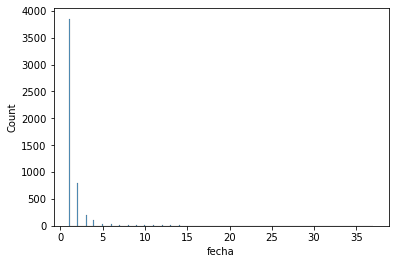

In [6]:
sns.histplot(df.groupby(by=['distrito', 'lugar_accidente']).agg('count').iloc[: ,0])

# La mayoria de los sitios sólo recogen un accidente
# Tiene una distribución logaritmica

* Filtro de columnas de interes

In [7]:
df_filtered = df[[
    'fecha', 'rango_horario', 'hora',
    'distrito', 'lugar_accidente', 'coordenada_x_utm', 'coordenada_y_utm',
    'tipo_accidente', 'num_victimas'
    ]].copy(deep=True)

df_filtered = df_filtered[~df_filtered.isna().T.all()].copy(deep=True)
df_filtered.shape

(8362, 9)

In [8]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8362 entries, 0 to 172
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fecha             8362 non-null   object 
 1   rango_horario     5524 non-null   object 
 2   hora              2838 non-null   object 
 3   distrito          8362 non-null   object 
 4   lugar_accidente   8362 non-null   object 
 5   coordenada_x_utm  2838 non-null   object 
 6   coordenada_y_utm  2838 non-null   object 
 7   tipo_accidente    8362 non-null   object 
 8   num_victimas      5524 non-null   float64
dtypes: float64(1), object(8)
memory usage: 653.3+ KB


Hay muchos elementos nulos: de `1030362` hay sólo un max de `8362` con dato; tiene pinta que el formato de recogida de datos cambió en algún momento en el tiempo:
* Se ha cambiado la forma en que se recoge la hora: antes se recogía la franja horaria y ahora se recoge la hora del accidente
* Las coordenadas parece que también es algo nuevo.

In [9]:
df_filtered.head()

,fecha,rango_horario,hora,distrito,lugar_accidente,coordenada_x_utm,coordenada_y_utm,tipo_accidente,num_victimas
0,01/01/2017,DE 6:00 A 6:59,NaN,ARGANZUELA,CALLE DE TOLEDO NUM ...,NaN,NaN,CHOQUE CON OBJETO FIJO,1.0
1,02/01/2017,DE 21:00 A 21:59,NaN,SAN BLAS,CALLE DE MEQUINENZA NUM ...,NaN,NaN,CAÍDA BICICLETA,1.0
2,03/01/2017,DE 19:00 A 19:59,NaN,CENTRO,CALLE DE LA ESCALINATA NUM ...,NaN,NaN,CAÍDA BICICLETA,1.0
3,04/01/2017,DE 21:00 A 21:59,NaN,CENTRO,CALLE DE LA CAVA DE SAN MIGUEL NUM ...,NaN,NaN,CAÍDA BICICLETA,1.0
4,05/01/2017,DE 8:00 A 8:59,NaN,MONCLOA-ARAVACA,PUENTE DE LOS FRANCESES ...,NaN,NaN,CAÍDA BICICLETA,1.0


In [10]:
new_ranges = {
    'rango_horario': [
        ['DE 10:00 A 10:59', 'DE 11:00 A 11:59', 'DE 12:00 A 12:59', 'DE 13:00 A 13:59',],
        ['DE 14:00 A 14:59', 'DE 15:00 A 15:59', 'DE 16:00 A 16:59', 'DE 17:00 A 17:59'],
        ['DE 18:00 A 18:59', 'DE 19:00 A 19:59', 'DE 20:00 A 20:59', 'DE 21:00 A 21:59'],
        ['DE 22:00 A 22:59', 'DE 23:00 A 23:59', 'DE 00:00 A 00:59', 'DE 1:00 A 1:59'],
        ['DE 2:00 A 2:59',   'DE 3:00 A 3:59',   'DE 4:00 A 4:59',   'DE 5:00 A 5:59'],
        ['DE 6:00 A 6:59',   'DE 7:00 A 7:59',   'DE 8:00 A 8:59',   'DE 9:00 A 9:59']
    ],
    'hora':  [ 
        (10, 13), (14, 17), (18, 21), (22, 1), (2, 5),(6, 9)
    ]
}

def classify_hours(cell:str, new_ranges:list) -> str or None:
    """ Classifies the hour ranges from the dataframe
    """    
    new_value = ''

    for i, nr in enumerate(new_ranges):

        if isinstance(nr, tuple):            
            if nr[0] <= cell <= nr[1]: 
                new_value = str(i)

        elif isinstance(nr, list):            
            if cell in nr:
                new_value = str(i)

        else:
            pass
    
    return new_value

def get_first_notnull_in_row(row):

    notnull_col = row.first_valid_index()
    return row[notnull_col]



df_filtered['hour_ranges_1'] = df_filtered['rango_horario'].apply(
    lambda c: classify_hours(cell=c, new_ranges=new_ranges['rango_horario']) if str(c).lower() != 'nan' else None
)
df_filtered['hour_ranges_2'] = df_filtered['hora'].apply(
    lambda c: classify_hours(cell=int(str(c)[0:2].strip(':')), new_ranges=new_ranges['hora']) if str(c) != 'nan' else None
)

df_filtered['hour_range'] = df_filtered[['hour_ranges_1', 'hour_ranges_2']].apply(lambda r: get_first_notnull_in_row(row=r), axis = 1)
df_filtered.drop(columns=['hour_ranges_1', 'hour_ranges_2', 'rango_horario', 'hora'],inplace=True)
	

Una vez que hemos limpiado los rangos horarios, vamos a ver con el nivel de lesividad y el número de victimas

In [11]:
renaming_accidente = {
    'ColisiÃ³n fronto-lateral':         'ATROPELLO', 
    'CaÃ\xadda':                        'CAÍDA BICICLETA', 
    'Alcance':                          'ATROPELLO',
    'ColisiÃ³n lateral':                'ATROPELLO', 
    'Atropello a persona':              'ATROPELLO',
    'Choque contra obstÃ¡culo fijo':    'CHOQUE CON OBJETO FIJO', 
    'ColisiÃ³n frontal':                'ATROPELLO', 
    'Otro':                             'OTRAS CAUSAS',
    'Atropello a animal':               'ATROPELLO', 
    'ColisiÃ³n mÃºltiple':              'COLISIÓN MÚLTIPLE', 
    'Vuelco':                           'VUELCO',
    'Solo salida de la vÃ\xada':        'CAÍDA MOTOCICLETA'
}

renaming_accidente.update({v: v.strip() for v in [
    'CHOQUE CON OBJETO FIJO                  ',
    'CAÍDA BICICLETA                         ',
    'ATROPELLO                               ',
    'COLISIÓN DOBLE                          ',
    'CAÍDA MOTOCICLETA                       ',
    'CAÍDA VIAJERO BUS                       ',
    'COLISIÓN MÚLTIPLE                       ',
    'OTRAS CAUSAS                            ',
    'CAÍDA CICLOMOTOR                        ',
    'VUELCO                                  '
    ]   
})

df_filtered['tipo_accidente'] = df_filtered['tipo_accidente'].map(renaming_accidente)
df_filtered['tipo_accidente'] = df_filtered['tipo_accidente'].apply(pythonise_string)

In [12]:
df_filtered.head()

,fecha,distrito,lugar_accidente,coordenada_x_utm,coordenada_y_utm,tipo_accidente,num_victimas,hour_range
0,01/01/2017,ARGANZUELA,CALLE DE TOLEDO NUM ...,NaN,NaN,choque_con_objeto_fijo,1.0,5
1,02/01/2017,SAN BLAS,CALLE DE MEQUINENZA NUM ...,NaN,NaN,caída_bicicleta,1.0,2
2,03/01/2017,CENTRO,CALLE DE LA ESCALINATA NUM ...,NaN,NaN,caída_bicicleta,1.0,2
3,04/01/2017,CENTRO,CALLE DE LA CAVA DE SAN MIGUEL NUM ...,NaN,NaN,caída_bicicleta,1.0,2
4,05/01/2017,MONCLOA-ARAVACA,PUENTE DE LOS FRANCESES ...,NaN,NaN,caída_bicicleta,1.0,5


* Pasar coordenadas a geometrías

In [13]:
df_filtered['coordenada_y_utm'] = df_filtered['coordenada_y_utm'].apply(lambda c: int(str(c).replace('.', ''))/1000000 if str(c) != 'nan' else None)
df_filtered['coordenada_x_utm'] = df_filtered['coordenada_x_utm'].apply(lambda c: int(str(c).replace('.', ''))/1000000 if str(c) != 'nan' else None)

gdf = gpd.GeoDataFrame(
    df_filtered, 
    geometry=gpd.points_from_xy(x=df_filtered['coordenada_x_utm'], y=df_filtered['coordenada_y_utm']), 
    crs='EPSG:25830'
).to_crs(4326)

gdf.drop(columns=['coordenada_y_utm', 'coordenada_x_utm'], inplace =True)

In [14]:
gdf.head()

,fecha,distrito,lugar_accidente,tipo_accidente,num_victimas,hour_range,geometry
0,01/01/2017,ARGANZUELA,CALLE DE TOLEDO NUM ...,choque_con_objeto_fijo,1.0,5,POINT EMPTY
1,02/01/2017,SAN BLAS,CALLE DE MEQUINENZA NUM ...,caída_bicicleta,1.0,2,POINT EMPTY
2,03/01/2017,CENTRO,CALLE DE LA ESCALINATA NUM ...,caída_bicicleta,1.0,2,POINT EMPTY
3,04/01/2017,CENTRO,CALLE DE LA CAVA DE SAN MIGUEL NUM ...,caída_bicicleta,1.0,2,POINT EMPTY
4,05/01/2017,MONCLOA-ARAVACA,PUENTE DE LOS FRANCESES ...,caída_bicicleta,1.0,5,POINT EMPTY


* Una vez que tenemos las geometrías, tenemos que asociar a cada direccion con geometría vacia, un punto (si se puede)

In [15]:
import re 

def simplify_callejero(cell:str) -> str:
    """ Given a string from a street, deletes everythin that it is not necessary to 
    make an aproximation to an adress
    """
    remove_from_viario = [
        'CALLE', 'DE', 'NUM', 'PASEO.', 'CALL', 'AVDA', 'la', 'PASEO', '19,', '25', '00350I', '1', '5A', '3', '30A', 
        '25A', '63', 'FRENTE AL NÃ MERO 69', 'SENDA', 'CICLABLE', 'AVENIDA', 'DEL', 'PUENTE', 'LOS', 'GLORIETA', 'LA',
        'MONASTERIO', 'PLAZA', 'LAS', 'AUTOVIA', 'PUERTA', 'PARQUE', 'CARRETERA', 'KM', 'BULEVAR', 'RIBERA', 'AL', 'FRENTE'
    ]

    new_string = re.findall('\w+', cell)
    new_string = " ".join([_ for _ in new_string if _ not in remove_from_viario])
    new_string = re.findall('\D+', new_string)

    return " ".join(new_string)

gdf['lugar'] = gdf['lugar_accidente'].apply(simplify_callejero)


In [16]:
geometries_by_lugar = gdf[~gdf['geometry'].is_empty].copy()

for col in geometries_by_lugar.columns:
    
    if geometries_by_lugar[col].isna().sum() == geometries_by_lugar.shape[0]:
        geometries_by_lugar.drop(columns=col, inplace=True)

geometries_by_lugar.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2838 entries, 0 to 172
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   fecha            2838 non-null   object  
 1   distrito         2838 non-null   object  
 2   lugar_accidente  2838 non-null   object  
 3   tipo_accidente   2838 non-null   object  
 4   hour_range       2838 non-null   object  
 5   geometry         2838 non-null   geometry
 6   lugar            2838 non-null   object  
dtypes: geometry(1), object(6)
memory usage: 177.4+ KB


In [17]:
geometries_by_lugar = geometries_by_lugar.dissolve(['distrito', 'lugar'])
geometries_by_lugar['geometry'] = geometries_by_lugar['geometry'].centroid
geometries_by_lugar = geometries_by_lugar.reset_index()[['distrito', 'lugar', 'geometry']]

/tmp/ipykernel_4670/2875141262.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geometries_by_lugar['geometry'] = geometries_by_lugar['geometry'].centroid


In [21]:
import Levenshtein

levenshtein_dist = {}

for initial in gdf['lugar_accidente'].values:
    levenshtein_dist[initial] = []
    for end in geometries_by_lugar['lugar'].values:
        levenshtein_dist[initial].append(Levenshtein.ratio(initial, end))

In [24]:
df = pd.DataFrame.from_dict(levenshtein_dist, orient='index', columns=geometries_by_lugar['lugar'].values)
df.T.idxmax().reset_index().rename(columns={'index':'lugar', 0:'new'})

,lugar,new
0,CALLE DE TOLEDO NUM ...,EMBARCADERO ENTRE FAROLAS NÂº Y
1,CALLE DE MEQUINENZA NUM ...,EMBARCADERO ENTRE FAROLAS NÂº Y
2,CALLE DE LA ESCALINATA NUM ...,ALCALDE SAINZ BARANDA AUTOV M
3,CALLE DE LA CAVA DE SAN MIGUEL NUM ...,CANILLEJAS A VICALVARO SANTA TECLA
4,PUENTE DE LOS FRANCESES ...,GENERAL RICARDOS FRANCISCO MORANO
...,...,...
4988,CALL. DOCTOR SANCHEZ / CALL. PUERTO DE LA MORC...,DOCTOR SANCHEZ PUERTO MORCUERA
4989,"PASEO. INFANTA ISABEL, 25",INFANTA ISABEL
4990,CALL. NURIA / CALL. PEÃA SIRIO,NURIA PEÃ A SIRIO
4991,"PQUE. MADRID RIO, +00350I",PQUE MADRID RIO I


In [30]:
geometries_by_lugar.merge(
    df.T.idxmax().reset_index().rename(columns={'index':'old', 0:'new'}), 
    left_on='lugar', 
    right_on='new'
).shape

(5575, 5)

In [31]:
geometries_by_lugar.shape

(1808, 3)